Define the attack tree

In [1]:
from pleenok.model.attack_tree import Gate, GateType

o1 = Gate(GateType.SEQUENCE_AND)
o1.add_attack("Exploit software")
o2 = o1.add_gate(GateType.AND, "Entered")
o1.add_attack("Run malicious script")
o3 = o2.add_gate(GateType.OR)
o2.add_attack("Get credentials")
o4 = o3.add_gate(GateType.AND)
o4.add_attack("Spoof MAC address")
o4.add_attack("Find LAN port")
o5 = o3.add_gate(GateType.AND)
o5.add_attack("Break WPA keys")
o5.add_attack("Find WLAN")

Visualize the attack tree

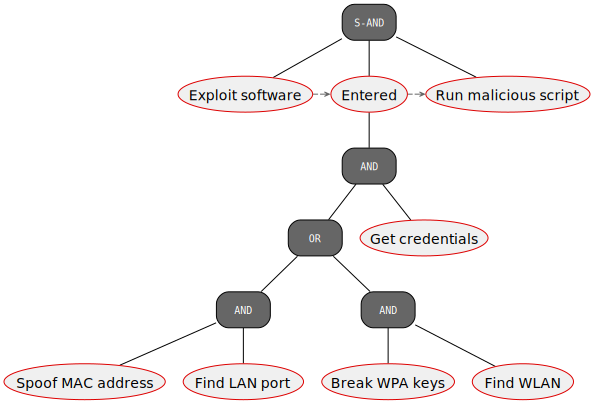

In [2]:
from pleenok.conversion.graphviz import generate_dot

generate_dot(o1)

Conversion to process tree and ADTool term

In [3]:
from pleenok.conversion.process_tree import attack_tree_to_process_tree_string
from pleenok.conversion.adtool import attack_tree_to_adtool_term

print(attack_tree_to_process_tree_string(o1))
print(attack_tree_to_adtool_term(o1))

->('Exploit software',+(O(+('Spoof MAC address','Find LAN port'),+('Break WPA keys','Find WLAN')),'Get credentials'),'Run malicious script')
SAND(Exploit software,AND(OR(AND(Spoof MAC address,Find LAN port),AND(Break WPA keys,Find WLAN)),Get credentials),Run malicious script)
